In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [5]:
!rm -rf data

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None,droprate=0):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.droprate = droprate

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        if self.droprate > 0:
          out = nn.dropout(out, p=self.droprate)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [ ]:
# Hyper-parameters
# num_epochs = 80
# learning_rate = 0.001

num_epochs = 20
learning_rate = 0.001

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)

Epoch [1/20], Step [500/500] Loss: 1.2049
Epoch [2/20], Step [500/500] Loss: 0.8506
Epoch [3/20], Step [500/500] Loss: 0.7727
Epoch [4/20], Step [500/500] Loss: 0.5005
Epoch [5/20], Step [500/500] Loss: 0.6764
Epoch [6/20], Step [500/500] Loss: 0.6277
Epoch [7/20], Step [500/500] Loss: 0.6950
Epoch [8/20], Step [500/500] Loss: 0.7026
Epoch [9/20], Step [500/500] Loss: 0.6363
Epoch [10/20], Step [500/500] Loss: 0.3763
Epoch [11/20], Step [500/500] Loss: 0.3761
Epoch [12/20], Step [500/500] Loss: 0.4221
Epoch [13/20], Step [500/500] Loss: 0.3991
Epoch [14/20], Step [500/500] Loss: 0.5307
Epoch [15/20], Step [500/500] Loss: 0.3409
Epoch [16/20], Step [500/500] Loss: 0.3844
Epoch [17/20], Step [500/500] Loss: 0.4563
Epoch [18/20], Step [500/500] Loss: 0.2636
Epoch [19/20], Step [500/500] Loss: 0.3348
Epoch [20/20], Step [500/500] Loss: 0.3573


In [ ]:
model.eval()
with torch.no_grad():
    angle_arr = []
    accuracy_arr = []
    for angle in range(0,370,10):
      correct = 0
      total = 0
      for images, labels in test_loader:
        imgs = F.rotate(images, angle)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      # print(angle)
      # print(correct,total)
      angle_arr.append(angle)
      accuracyVal = 100 * correct / total
      accuracy_arr.append(accuracyVal)
      # import torchvision.transforms as T
      # from PIL import Image
      # transform = T.ToPILImage()
      # display(transform(images[4]),transform(imgs[4]))
      # print()

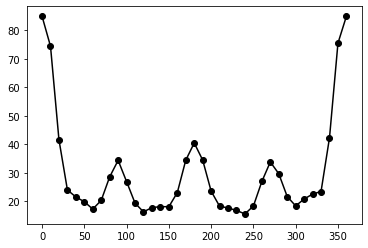

In [ ]:
plt.plot(angle_arr, accuracy_arr, '-ok')
# plt.gca().invert_xaxis()

# L1 Regularization 

In [ ]:
l1_lambda = 0.0001

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        l1_parameters = []
        for parameter in model.parameters():
          l1_parameters.append(parameter.view(-1))
        l1_penalty = l1_lambda * model.compute_l1_loss(torch.cat(l1_parameters))  
        loss = criterion(outputs, labels) + l1_penalty

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    

Epoch [1/20], Step [500/500] Loss: 1.8916
Epoch [2/20], Step [500/500] Loss: 2.0120
Epoch [3/20], Step [500/500] Loss: 2.0746
Epoch [4/20], Step [500/500] Loss: 1.9141
Epoch [5/20], Step [500/500] Loss: 1.9374
Epoch [6/20], Step [500/500] Loss: 1.9261
Epoch [7/20], Step [500/500] Loss: 1.9566
Epoch [8/20], Step [500/500] Loss: 2.0213
Epoch [9/20], Step [500/500] Loss: 1.7618
Epoch [10/20], Step [500/500] Loss: 2.1035
Epoch [11/20], Step [500/500] Loss: 1.9481
Epoch [12/20], Step [500/500] Loss: 1.9307
Epoch [13/20], Step [500/500] Loss: 1.9535
Epoch [14/20], Step [500/500] Loss: 2.0139
Epoch [15/20], Step [500/500] Loss: 1.8650
Epoch [16/20], Step [500/500] Loss: 1.8920
Epoch [17/20], Step [500/500] Loss: 1.9350
Epoch [18/20], Step [500/500] Loss: 1.9782
Epoch [19/20], Step [500/500] Loss: 1.9437
Epoch [20/20], Step [500/500] Loss: 1.9039


In [ ]:
model.eval()
with torch.no_grad():
    l1_angle_arr = []
    l1_accuracy_arr = []
    for angle in range(0,370,10):
      correct = 0
      total = 0
      for images, labels in test_loader:
        imgs = F.rotate(images, angle)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      # print(angle)
      # print(correct,total)
      l1_angle_arr.append(angle)
      accuracyVal = 100 * correct / total
      l1_accuracy_arr.append(accuracyVal)

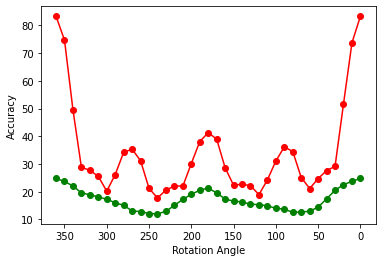

In [ ]:
plt.plot(angle_arr, accuracy_arr, 'or-',label='resnet50')
plt.plot(l1_angle_arr, l1_accuracy_arr, 'og-',label='resnet50 with L1 regularisation')
plt.xlabel('Rotation Angle')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()

# L2 Regularization 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.0001)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    

Epoch [1/20], Step [500/500] Loss: 1.7618
Epoch [2/20], Step [500/500] Loss: 1.8358
Epoch [3/20], Step [500/500] Loss: 1.8566
Epoch [4/20], Step [500/500] Loss: 1.7631
Epoch [5/20], Step [500/500] Loss: 1.7824
Epoch [6/20], Step [500/500] Loss: 1.8545
Epoch [7/20], Step [500/500] Loss: 1.8920
Epoch [8/20], Step [500/500] Loss: 1.7227
Epoch [9/20], Step [500/500] Loss: 1.9149
Epoch [10/20], Step [500/500] Loss: 1.7747
Epoch [11/20], Step [500/500] Loss: 1.8112
Epoch [12/20], Step [500/500] Loss: 1.8106
Epoch [13/20], Step [500/500] Loss: 1.8132
Epoch [14/20], Step [500/500] Loss: 1.7671
Epoch [15/20], Step [500/500] Loss: 1.7735
Epoch [16/20], Step [500/500] Loss: 1.6553
Epoch [17/20], Step [500/500] Loss: 1.5944
Epoch [18/20], Step [500/500] Loss: 1.7670
Epoch [19/20], Step [500/500] Loss: 1.7290
Epoch [20/20], Step [500/500] Loss: 1.6802


In [ ]:
model.eval()
with torch.no_grad():
    l2_angle_arr = []
    l2_accuracy_arr = []
    for angle in range(0,370,10):
      correct = 0
      total = 0
      for images, labels in test_loader:
        imgs = F.rotate(images, angle)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      # print(angle)
      # print(correct,total)
      l2_angle_arr.append(angle)
      accuracyVal = 100 * correct / total
      l2_accuracy_arr.append(accuracyVal)

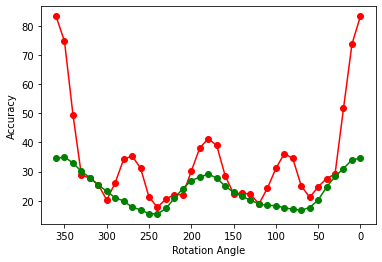

In [ ]:
plt.plot(angle_arr, accuracy_arr, 'or-',label='resnet50')
plt.plot(l2_angle_arr, l2_accuracy_arr, 'og-',label='resnet50 with L2 regularisation')
plt.xlabel('Rotation Angle')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()

# Dropout

In [ ]:
model = ResNet(ResidualBlock, [2, 2, 2,None,0.1]).to(device)

In [ ]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 500 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # # Decay learning rate
    # if (epoch+1) % 20 == 0:
    #     curr_lr /= 3
    #     update_lr(optimizer, curr_lr)
    

Epoch [1/20], Step [500/500] Loss: 2.4351
Epoch [2/20], Step [500/500] Loss: 2.4537
Epoch [3/20], Step [500/500] Loss: 2.3582
Epoch [4/20], Step [500/500] Loss: 2.3806
Epoch [5/20], Step [500/500] Loss: 2.3687
Epoch [6/20], Step [500/500] Loss: 2.3922
Epoch [7/20], Step [500/500] Loss: 2.4520
Epoch [8/20], Step [500/500] Loss: 2.3565
Epoch [9/20], Step [500/500] Loss: 2.5116
Epoch [10/20], Step [500/500] Loss: 2.5248
Epoch [11/20], Step [500/500] Loss: 2.4091
Epoch [12/20], Step [500/500] Loss: 2.5002
Epoch [13/20], Step [500/500] Loss: 2.3719
Epoch [14/20], Step [500/500] Loss: 2.4662
Epoch [15/20], Step [500/500] Loss: 2.3963
Epoch [16/20], Step [500/500] Loss: 2.4324
Epoch [17/20], Step [500/500] Loss: 2.4479
Epoch [18/20], Step [500/500] Loss: 2.3941
Epoch [19/20], Step [500/500] Loss: 2.3400
Epoch [20/20], Step [500/500] Loss: 2.3821


In [ ]:
model.eval()
with torch.no_grad():
    dp_angle_arr = []
    dp_accuracy_arr = []
    for angle in range(0,370,10):
      correct = 0
      total = 0
      for images, labels in test_loader:
        imgs = F.rotate(images, angle)
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      # print(angle)
      # print(correct,total)
      dp_angle_arr.append(angle)
      accuracyVal = 100 * correct / total
      dp_accuracy_arr.append(accuracyVal)

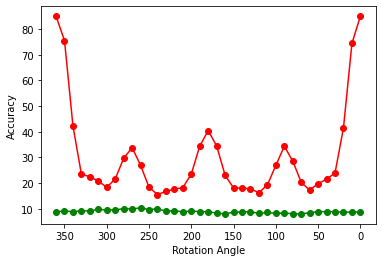

In [ ]:
plt.plot(angle_arr, accuracy_arr, 'or-',label='resnet50')
plt.plot(dp_angle_arr, dp_accuracy_arr, 'og-',label='resnet50 with L2 regularisation')
plt.xlabel('Rotation Angle')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()

# Transformation Test

In [7]:
images, classes = next(iter(test_loader))

In [8]:
images[0].shape

torch.Size([3, 32, 32])

In [9]:
import torchvision.transforms.functional as TF
# imgarr = F.adjust_brightness(images, 0.5)
imgarr = TF.rotate(images, 45)

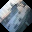

In [11]:
import torchvision.transforms as T
from PIL import Image
transform = T.ToPILImage()
img = transform(imgarr[2])
display(img)

In [ ]:
imgarr[2]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')

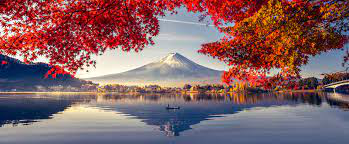

In [ ]:
import torch
from PIL import Image
import torchvision.transforms.functional as F

# read the input image
img = Image.open('download.jpg')

# adjust the brightness of image
img

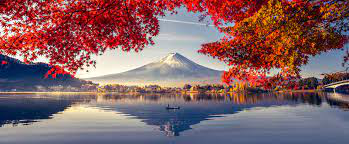

In [ ]:
img = F.rotate(img, 360)

# display the brightness adjusted image
img